## PSD + TVB LFPs results

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fftpack import fft, rfft, fftfreq
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.signal import butter, lfilter


my_layout = widgets.Layout()

In [2]:
# define a filter to separate gamma frequency and theta frequency

def fir_bandpass(data, fs, cut_off_low, cut_off_high, width=2.0, ripple_db=10.0):
    """
    The FIR bandpass filter
    """
    nyq_rate = fs / 2.0
    wid = width/nyq_rate
    N, beta = signal.kaiserord(ripple_db, wid)
    taps = signal.firwin(N, cutoff = [cut_off_low, cut_off_high],
                  window = 'hamming', pass_zero = False, fs=fs)
    filtered_signal = signal.lfilter(taps, 1.0, data)
    return filtered_signal, N


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def psd(signal, samplinginterval):
    fourierSignal = np.fft.fft(np.array(signal) - np.array(signal).mean())
    spectrum = 2 * (1/fs) ** 2 / 1000 * (fourierSignal * fourierSignal.conj())
    spectrum = spectrum[:int(len(np.array(signal)) / 2)] 
    time_all = 1 / 1
    fNQ = 1/samplinginterval/2 # Nyquist frequency
    faxis = np.arange(0, fNQ, time_all) # frequency axis
    return faxis, spectrum.real
    

In [109]:
fs = 81920.0
samplinginterval = 1/fs
t = np.arange(0, 1, samplinginterval)
grps = ['SNC','NC','MCI','AD']
col = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
path = 'C:/Users/Wayne/tvb/stat_data/Gc_Go.xlsx'
coData = pd.read_excel(path, index_col=0)
print(coData)

def read_data(grp, caseid):
    gm = np.round(coData.loc[caseid, "Gc"], 3)
    dataFile = 'D:/data/LFP/'+str(grp)+'/'+str(caseid)+'/'+str(caseid)+'_'+str(gm)+'.csv'
    df = pd.read_csv(dataFile, index_col=0)
    dfL = df.iloc[:, 4]
    dfR = df.iloc[:, 5]
    fig, axs = plt.subplots(2, figsize=(15,7))
    #plt.suptitle(f"case: {}")
    
    cutoff_low = 2.
    freq_filter = 10.
    filter_R, N = fir_bandpass(np.array(dfR), fs, cutoff_low, freq_filter)
    filter_L, N = fir_bandpass(np.array(dfL), fs, cutoff_low, freq_filter)
    delay = 0.5 * (N-1) / fs
    # filter_R = butter_bandpass_filter(np.array(dfR), cutoff_low, freq_filter, fs, order=1)
    # filter_L = butter_bandpass_filter(np.array(dfL), cutoff_low, freq_filter, fs, order=1)
    
    axs[0].plot(t, dfL, color='k', label = 'PCG Left')
    axs[0].plot(t, dfR, color='r', label = 'PCG Right')
    axs[0].plot(t[N-1:]-delay, filter_L[N-1:], label = 'PCG Left theta')
    axs[0].plot(t[N-1:]-delay, filter_R[N-1:], label = 'PCG Right theta')
    axs[0].legend()
    
    psd_freq_right, psd_right = psd(np.array(dfR), samplinginterval)
    psd_freq_left, psd_left = psd(np.array(dfL), samplinginterval)
    axs[1].plot(psd_freq_left, psd_left, color= 'k', label = 'PCG Left')
    axs[1].plot(psd_freq_right, psd_right, color='r', label = 'PCG Right')
    axs[1].set(xlim=[0,100])
    axs[1].legend()

    # # welch
    # freqs, psds = signal.welch(filter_R, fs, nperseg=fs)
    # plt.figure(figsize=(15,7))
    # plt.plot(freqs, psds)
    # plt.title('PSD: power spectral density')
    # plt.xlabel('Frequency')
    # plt.ylabel('Power')
    # plt.xlim([0,100])

      groups     Go     Gc   Gmax  Go-Gc  Gmax-Gc
id                                               
2820A    SNC  0.015  0.014  0.032  0.001    0.018
3168A    SNC  0.025  0.010  0.043  0.015    0.033
3358A    SNC  0.030  0.016  0.021  0.014    0.005
3610A    SNC  0.030  0.015  0.048  0.015    0.033
4073A    SNC  0.018  0.010  0.017  0.008    0.007
...      ...    ...    ...    ...    ...      ...
3255A     AD  0.031  0.017  0.034  0.014    0.017
4612A     AD  0.012  0.010  0.022  0.002    0.012
5368A     AD  0.020  0.016  0.028  0.004    0.012
5571A     AD  0.031  0.015  0.020  0.016    0.005
7673A     AD  0.049  0.018  0.053  0.031    0.035

[74 rows x 6 columns]


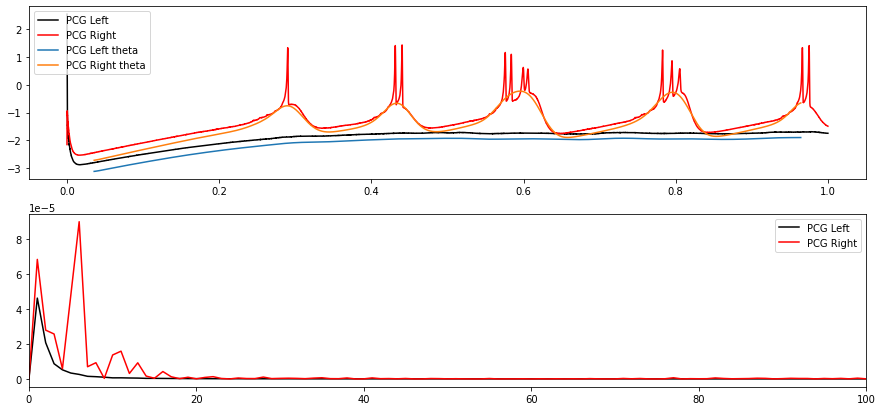

In [108]:
read_data(grp='AD', caseid='3255')

In [ ]:
@widgets.interact(gm=widgets.FloatSlider(0.001, min=0.001, max=0.070, step=0.001
                               ,layout=my_layout))

def plot_data(gm):
    read_data(gm)